In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("engineered_features_v4.csv")

print(f"Dataset shape: {df.shape}")
print(df['is_canceled'].value_counts(normalize=True))

cat_cols = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Drop NA if any remain
df.dropna(inplace=True)

Dataset shape: (117399, 54)
is_canceled
0    0.625116
1    0.374884
Name: proportion, dtype: float64


In [2]:
# TRAIN/VALIDATION SPLIT
# Temporal or stratified split
# If temporal: sort by reservation_status_date (if available)

if 'reservation_status_date' in df.columns:
    df = df.sort_values('reservation_status_date')

X = df.drop(columns=['is_canceled', 'reservation_status_date'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (93919, 52), Test: (23480, 52)


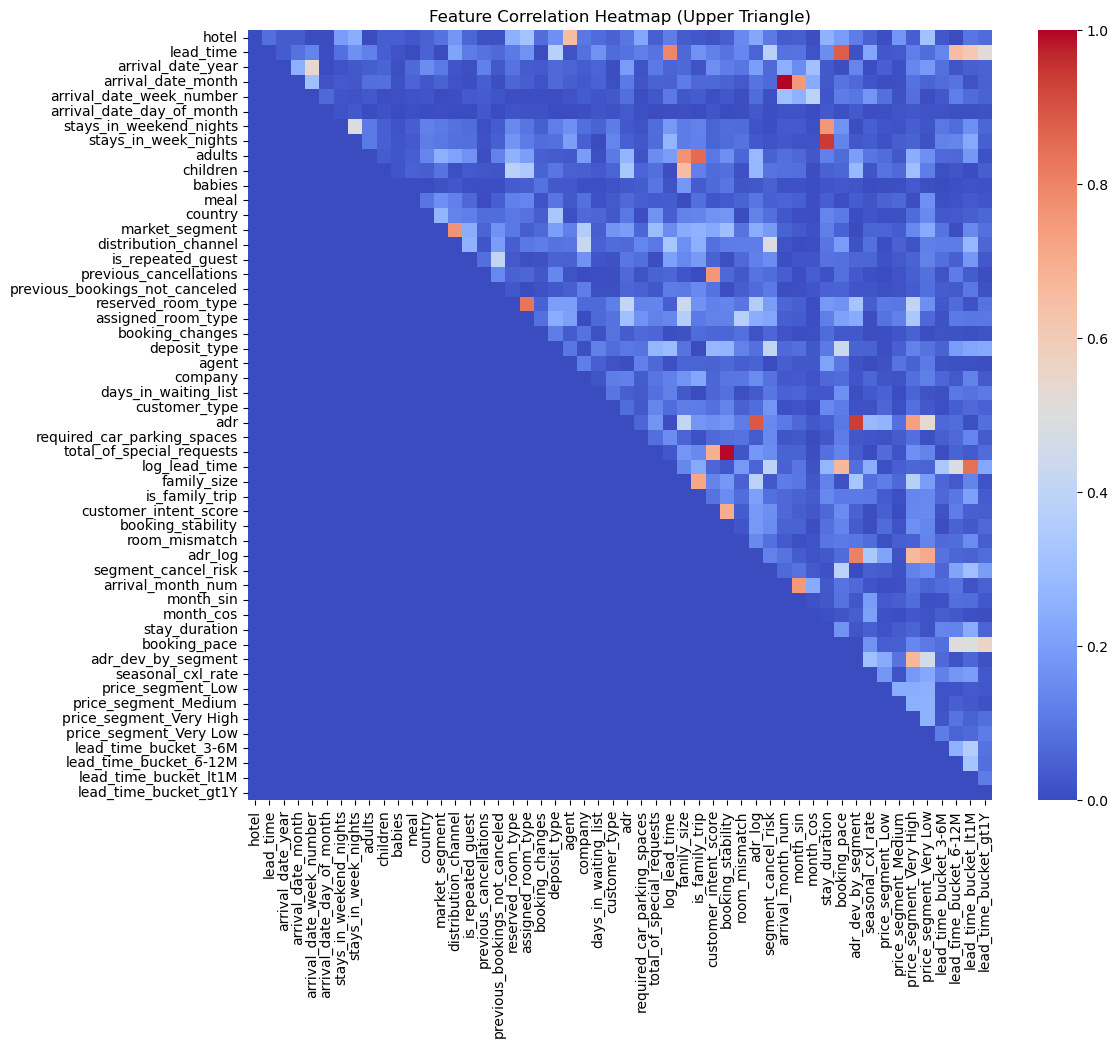

In [59]:
# FEATURE VALIDATION

# Correlation matrix
corr = X_train.corr().abs()
plt.figure(figsize=(12,10))
sns.heatmap(corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).fillna(0), cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Upper Triangle)')
plt.show()

In [27]:
# Variance check
low_var = [col for col in X_train.columns if X_train[col].var() < 1e-3]
print(f"Low variance features (drop candidates): {low_var}")

Low variance features (drop candidates): []


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# BASELINE MODELS

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic Regression
logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight='balanced', C = 1.0, n_jobs = -1)
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
y_prob_lr = logreg.predict_proba(X_test_scaled)[:,1]

In [5]:
from sklearn.calibration import CalibratedClassifierCV
import joblib

# Calibrate Logistic Regression probabilities 
calibrated_logreg = CalibratedClassifierCV(logreg, method="sigmoid", cv=3)
calibrated_logreg.fit(X_train_scaled, y_train)

# joblib.dump(calibrated_logreg, "hotel_logreg_calibrated_model", compress=3)

,estimator,"LogisticRegre...00, n_jobs=-1)"
,method,'sigmoid'
,cv,3
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [8]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth = 10, random_state=42, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [10]:
# Calibrate Random Forest probabilities (important for better probability quality)
calibrated_rf = CalibratedClassifierCV(rf, method="isotonic", cv=3)
calibrated_rf.fit(X_train, y_train)

# joblib.dump(calibrated_rf, "hotel_rf_calibrated_model", compress=3)

,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,3
,n_jobs,None
,ensemble,'auto'
,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [14]:
# XGBoost
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]), random_state = 42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

In [18]:
calibrated_xgb = CalibratedClassifierCV(xgb, method="isotonic", cv=3)
calibrated_xgb.fit(X_train, y_train)

# joblib.dump(calibrated_xgb, "hotel_xgb_calibrated_model", compress=3)

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,3
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [67]:
# METRICS FUNCTION

def evaluate_model(name, y_true, y_pred, y_prob):
    roc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{name} Results")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("Confusion Matrix:\n", cm)

    return {'Model': name, 'ROC_AUC': roc, 'PR_AUC': pr_auc, 'F1': f1, 'Precision': precision, 'Recall': recall}

# Evaluate models
results = []
results.append(evaluate_model('Logistic Regression', y_test, y_pred_lr, y_prob_lr))
results.append(evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf))
results.append(evaluate_model('XGBoost', y_test, y_pred_xgb, y_prob_xgb))


Logistic Regression Results
ROC-AUC: 0.8821 | PR-AUC: 0.8367 | F1: 0.7431 | Precision: 0.7052 | Recall: 0.7853
Confusion Matrix:
 [[11789  2889]
 [ 1890  6912]]

Random Forest Results
ROC-AUC: 0.9261 | PR-AUC: 0.8983 | F1: 0.7818 | Precision: 0.8624 | Recall: 0.7150
Confusion Matrix:
 [[13674  1004]
 [ 2509  6293]]

XGBoost Results
ROC-AUC: 0.9553 | PR-AUC: 0.9352 | F1: 0.8434 | Precision: 0.8052 | Recall: 0.8854
Confusion Matrix:
 [[12793  1885]
 [ 1009  7793]]


In [68]:
metrics_df = pd.DataFrame(results)
metrics_df.to_csv("model_metrics.csv", index=False)

In [69]:
import warnings
warnings.filterwarnings('ignore')

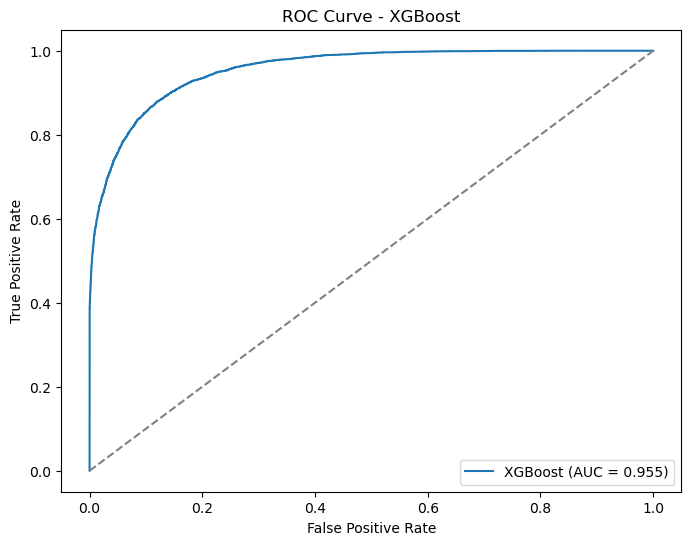

In [71]:
# ROC Curve Example for Best Model
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %.3f)' % roc_auc_score(y_test, y_prob_xgb))
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
#plt.savefig('roc_curve.png')
plt.show()

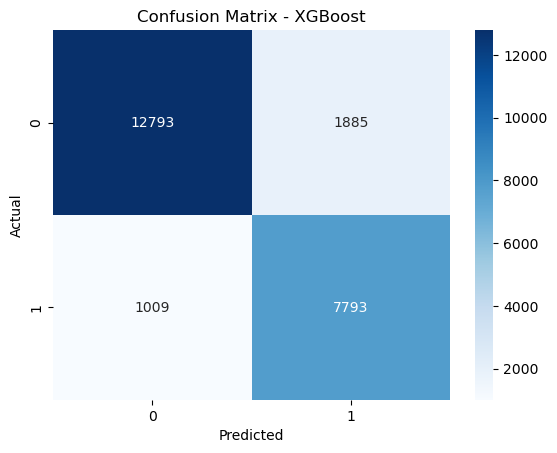

In [72]:
# Save confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig('confusion_matrix.png')
plt.show()

## SHAP Recalculation and Summary 

In [73]:
import shap, joblib, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import gc, os, psutil
from tqdm import tqdm

BASE = "."
df = pd.read_csv('engineered_features_v4.csv')
FEATURES_PATH = "outputs/hotel_feature_names.joblib"
SCALER_PATH = "outputs/scaler.joblib"
LOGREG_PATH = "outputs/hotel_logreg_model.joblib"
RF_PATH = "outputs/hotel_rf_model.joblib"
XGB_PATH = "outputs/hotel_xgb_model.joblib"

drop_cols = ["is_canceled", "reservation_status_date"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Utility: memory print helper
def print_mem(note=""):
    print(f"[{note}] Memory used: {psutil.virtual_memory().percent}%")

print_mem("Start")

# Data Loading
X = df
feature_names = joblib.load(FEATURES_PATH)
scaler = joblib.load(SCALER_PATH)

# reduce to smaller sample (low RAM)
X_sample = X.sample(n=min(500, len(X)), random_state=42)
print("Sample shape:", X_sample.shape)

# LOGISTIC REGRESSION SHAP 
from sklearn.preprocessing import StandardScaler

logreg = joblib.load(LOGREG_PATH)
scaler = joblib.load(SCALER_PATH)

# Scale data manually before passing to SHAP
X_scaled = scaler.transform(X_sample)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

explainer_logreg = shap.LinearExplainer(logreg, X_scaled_df, feature_names=feature_names)
shap_logreg_values = explainer_logreg.shap_values(X_scaled_df)

# Save SHAP values
joblib.dump(shap_logreg_values, "shap_values_logreg_recomputed.joblib", compress=3)

# Plot SHAP summary
plt.figure(figsize=(8,10))
shap.summary_plot(shap_logreg_values, X_scaled_df, feature_names=feature_names, show=False)
plt.tight_layout()
# plt.savefig("global_shap_summary_LogisticRegression_corrected.png", dpi=150)
plt.close()

print(" Logistic SHAP recomputed successfully.")
print_mem("After Logistic")
del shap_logreg_values, explainer_logreg, X_scaled_df, X_scaled, logreg
gc.collect()

[Start] Memory used: 79.4%
Sample shape: (500, 52)

 Logistic Regression SHAP (fixed no-pipeline)...
 Logistic SHAP recomputed successfully.
[After Logistic] Memory used: 78.9%


54108

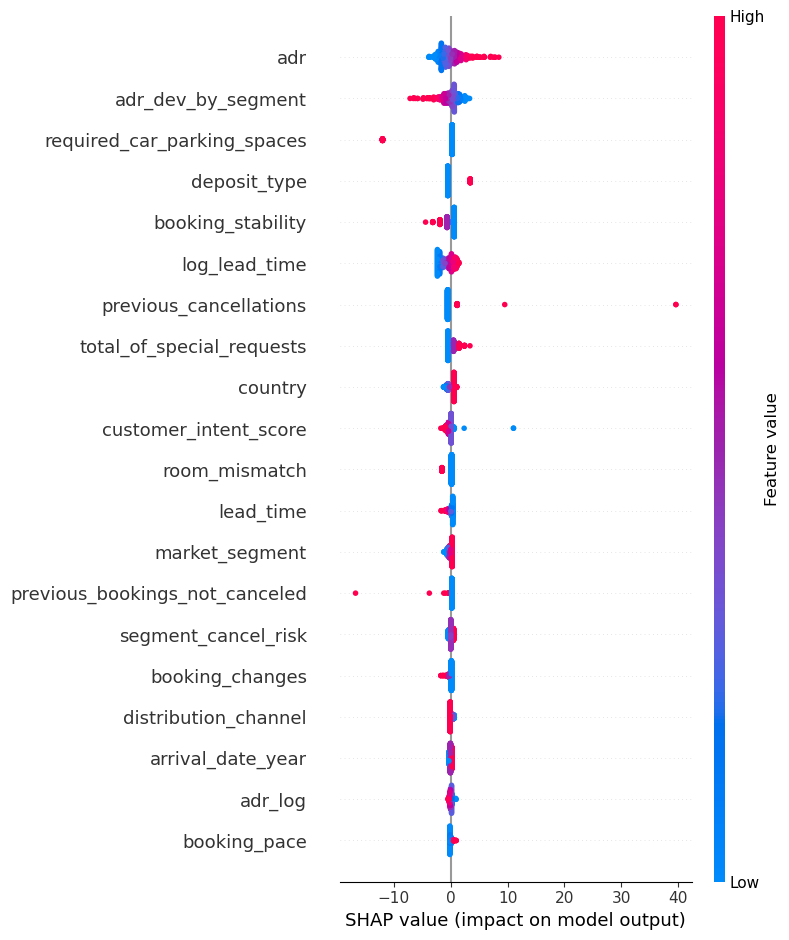

<Figure size 640x480 with 0 Axes>

In [54]:
# logistic regression SHAP
import shap, joblib, matplotlib.pyplot as plt
import pandas as pd

X_full = pd.read_csv("engineered_features_v4.csv")
drop_cols = ["is_canceled", "reservation_status_date"]
X_full = X_full.drop(columns=[c for c in drop_cols if c in X_full.columns])
feature_names = joblib.load("outputs/hotel_feature_names.joblib")
X_filtered = X_full[feature_names].sample(n=500, random_state=42)

shap_values = joblib.load("shap_values_logreg_recomputed.joblib")

# Plot summary
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values, X_filtered, feature_names=feature_names, show=True)
plt.tight_layout()
plt.show()

In [74]:
# RANDOM FOREST SHAP
print("\n Random Forest SHAP (approximate, low-memory mode)...")
try:
    rf = joblib.load(RF_PATH)
    explainer_rf = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent", feature_names=feature_names)
    shap_rf_values = explainer_rf.shap_values(X_sample)
    joblib.dump(shap_rf_values, "shap_values_rf_recomputed.joblib", compress=3)
    plt.figure(figsize=(8,10))
    shap.summary_plot(shap_rf_values, X_sample, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("global_shap_summary_RandomForest_corrected.png", dpi=150)
    plt.close()
    print("Random Forest SHAP done.")
    print_mem("After RF")
except Exception as e:
    print(" RF SHAP failed:", e)
del rf, explainer_rf, shap_rf_values
gc.collect()


 Random Forest SHAP (approximate, low-memory mode)...
Random Forest SHAP done.
[After RF] Memory used: 82.6%


10773

<Figure size 800x1000 with 0 Axes>

<Figure size 800x1000 with 0 Axes>

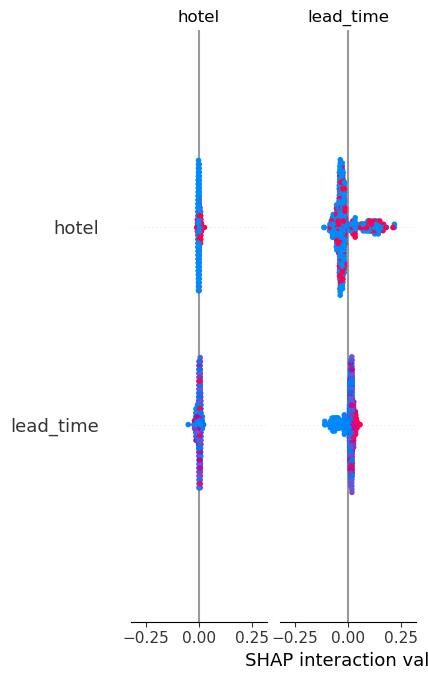

<Figure size 640x480 with 0 Axes>

In [55]:
shap_values = joblib.load("shap_values_rf_recomputed.joblib")

# Plot summary
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values, X_filtered, feature_names=feature_names, show=True)
plt.tight_layout()
plt.show()

In [75]:
# XGBOOST SHAP
print("\n XGBoost SHAP...")
try:
    xgb = joblib.load(XGB_PATH)
    explainer_xgb = shap.TreeExplainer(xgb, feature_names=feature_names)
    shap_xgb_values = explainer_xgb.shap_values(X_sample)
    joblib.dump(shap_xgb_values, "shap_values_xgb_recomputed.joblib", compress=3)
    plt.figure(figsize=(8,10))
    shap.summary_plot(shap_xgb_values, X_sample, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig("global_shap_summary_XGBoost_corrected.png", dpi=150)
    plt.close()
    print(" XGBoost SHAP done.")
    print_mem("After XGB")
except Exception as e:
    print(" XGBoost SHAP failed:", e)
del xgb
gc.collect()

print("\n SHAP recomputation complete.")



 XGBoost SHAP...
 XGBoost SHAP done.
[After XGB] Memory used: 82.3%

 SHAP recomputation complete.


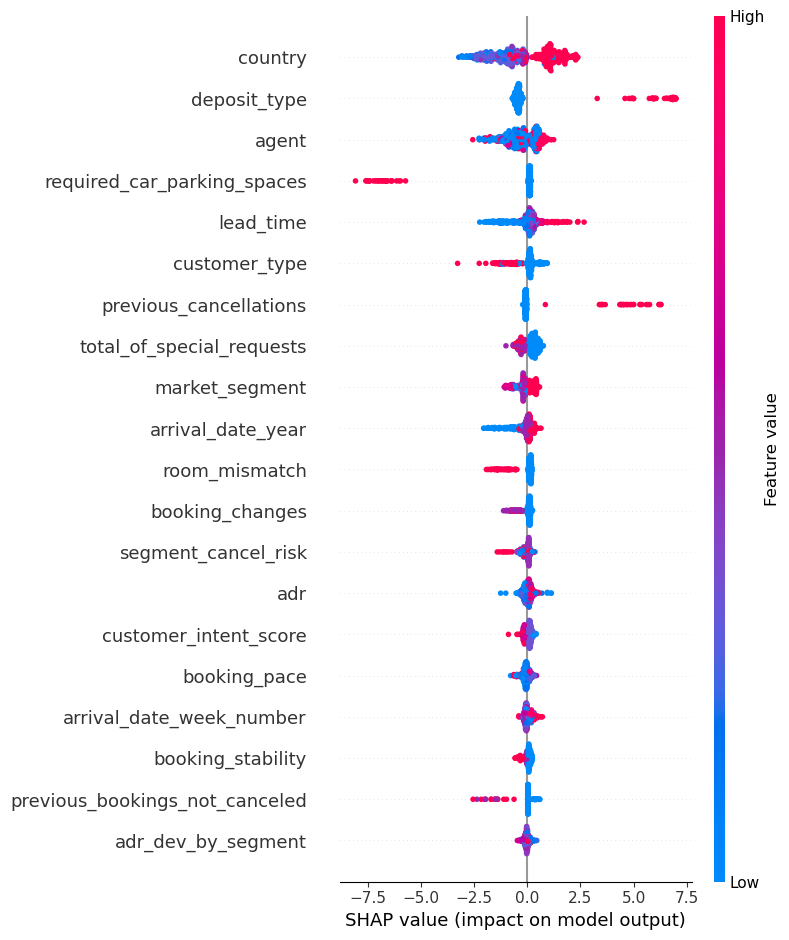

<Figure size 640x480 with 0 Axes>

In [56]:
shap_values = joblib.load("shap_values_xgb_recomputed.joblib")

# Plot summary
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values, X_filtered, feature_names=feature_names, show=True)
plt.tight_layout()
plt.show()

In [52]:
import joblib, numpy as np
vals = joblib.load("shap_values_logreg_recomputed.joblib")
print("Shape:", np.shape(vals))
print("Range:", np.nanmin(vals), "→", np.nanmax(vals))

Shape: (500, 52)
Range: -16.741308739252613 → 39.605017250342435


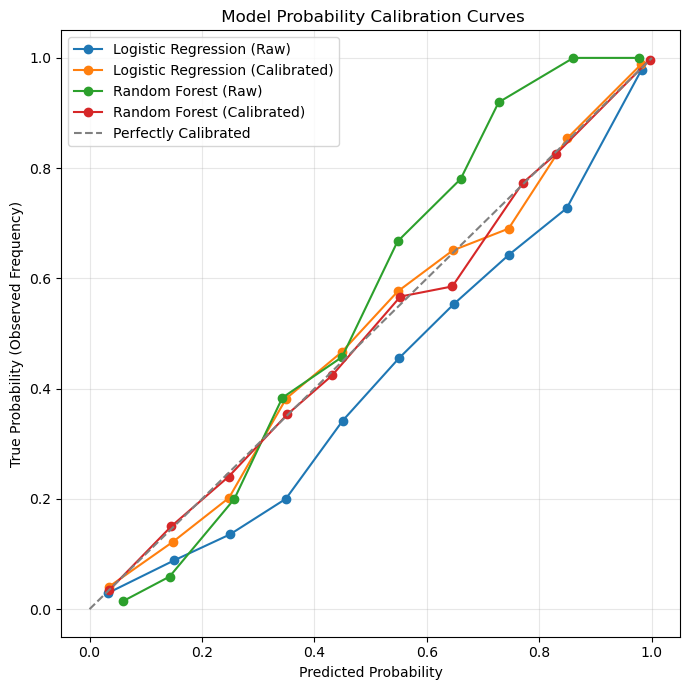

In [78]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import joblib

# Load test data and models
X_test_scaled = scaler.transform(X_test)
models = {
    "Logistic Regression (Raw)": joblib.load("outputs/hotel_logreg_model.joblib"),
    "Logistic Regression (Calibrated)": joblib.load("hotel_logreg_calibrated_model.joblib"),
    "Random Forest (Raw)": joblib.load("outputs/hotel_rf_model.joblib"),
    "Random Forest (Calibrated)": joblib.load("hotel_rf_calibrated_model.joblib")
}

plt.figure(figsize=(7, 7))

# Plot calibration curve for each model
for name, model in models.items():
    X_in = X_test_scaled if "Logistic" in name else X_test
    prob_true, prob_pred = calibration_curve(y_test, model.predict_proba(X_in)[:, 1], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

# Reference diagonal (perfect calibration)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.title(" Model Probability Calibration Curves")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability (Observed Frequency)")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("model_calibration_curves.png", dpi=150)
plt.show()